# Project!
## Business Question: 
### By David Shin and Khyatee Desai<br>Nov. 13, 2020

In [235]:
from zipfile import ZipFile 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle 
from itertools import combinations
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import set_config
set_config(print_changed_only=False, display=None)
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

In [217]:
# extract relevant csv files from zipped folder
with ZipFile("data/datasets.zip") as z:
    df = pd.read_csv(z.open(z.infolist()[0].filename))
#     df_artist = pd.read_csv(z.open(z.infolist()[1].filename))
#     df_avg_genre = pd.read_csv(z.open(z.infolist()[2].filename))
#     df_yr = pd.read_csv(z.open(z.infolist()[3].filename))
    df_genre = pd.read_csv(z.open(z.infolist()[4].filename))

In [218]:
df.sample(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
77244,0.0318,['Miguel'],0.551,197227,0.543,0,1OSkUAslVAljbEnG973Gfa,0.000078,2,0.285,-6.468,1,Arch & Point,43,2012-09-28,0.0638,158.005,0.185,2012
7907,0.0524,['物語シリーズ'],0.814,255040,0.785,0,5P8lyudWE7HQxb4ludLbEm,0.001110,1,0.111,-5.679,0,Renai Circulation,68,2018-11-02,0.0396,120.009,0.941,2018
159798,0.5450,['Mos Def'],0.564,251213,0.532,0,3ewIu3AibUiSiDNS0Ta8Lm,0.001260,11,0.238,-7.228,1,The Panties,47,2004-10-12,0.0391,85.118,0.182,2004


In [219]:
# drop irrelevant features
df_genre = df_genre[['artists', 'genres']]
df_genre.sample(3)

,artists,genres
19996,Res Fischer,[]
9885,Henry Jamison,"['indie anthem-folk', 'indie folk', 'neo mello..."
16411,Mighty High Coup,[]


In [220]:
# unpack lists in the Artists column, retain the first artist of the list
df['artists'] = df['artists'].str.slice(1,-1).str.split(',')
df['artists'] = df['artists'].map(lambda x: x[0])
df['artists'] = df['artists'].str.slice(1,-1)

In [221]:
# Join together datasets on artist name
merged =df.merge(df_genre, on='artists')

# Keep rows within 'rock' genre
rock_df =merged[merged['genres'].str.contains('rock')]
rock_df.sample(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,genres
156161,0.005130,Buffalo Tom,0.303,224840,0.862,0,6nncZzBlYV9wXkkjZBzVWD,0.000000,4,0.0874,-8.539,0,Taillights Fade,38,1992,0.0511,85.562,0.279,1992,"['alternative pop', 'alternative rock', 'bosto..."
82328,0.000573,George Michael,0.748,288067,0.564,0,2hn7TTNtOX7iMF0vUIhwc3,0.300000,10,0.0554,-11.041,0,Hard Day - Remastered,33,1987-10-30,0.0740,95.511,0.212,1987,"['dance rock', 'new wave pop', 'soft rock']"
87084,0.036200,Rage Against The Machine,0.404,309173,0.834,1,4rEPAJKYF5FuCN62NIYPOU,0.000147,4,0.4910,-5.965,1,Bullet In The Head - Demo,38,1992,0.1180,165.909,0.545,1992,"['alternative metal', 'alternative rock', 'con..."


In [222]:
# Create target variable based on year ranges
conditions = [
    (rock_df['year'] >=1950) & (rock_df['year'] <1970),
    (rock_df['year'] >=1970) & (rock_df['year'] <1990),
    (rock_df['year'] >=1990) & (rock_df['year'] <2010)]
choices = [
    '50s/60s', '70s/80s', '90s/2000s']
rock_df['era'] = np.select(conditions, choices, default='NA')

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [223]:
# drop rows with dates outside the relevant ranges
rock_df = rock_df[rock_df['era'] !='NA']

# drop irrelevant features
rock_df.drop(['artists', 'id', 'name', 'release_date', 'genres', 'year'], axis=1, inplace=True)

In [268]:
y = rock_df['era']
X = rock_df.drop(['era'], axis=1)

In [231]:
# check class imbalance of target
y.value_counts()

70s/80s      25392
90s/2000s    15530
50s/60s       9574
Name: era, dtype: int64

### Impute Outliers

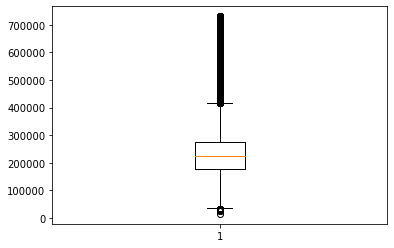

In [270]:
# Bring outliers down/up to 5 standard deviations from the mean
for feat in X:
    abv_5_std = X[feat].mean()+ 5*X[feat].std()
    below_5_std = X[feat].mean()- 5*X[feat].std()
    conditions = [X[feat]>abv_5_std, X[feat]<below_5_std]
    choices = [abv_5_std, below_5_std]
    X[feat] = np.select(conditions, choices, X[feat])

plt.boxplot(X.duration_ms);

# EDA

# Feature Engineering

# Preliminary Modeling

# Hyperparameter Tuning

# Model Evaluation

# Final Model & Conclusion